# Word2Vec 를 통한 위픽 개인화 테스트



In [1]:
import requests
import time
import urllib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import elasticsearch
import csv
import pickle
from elasticsearch.helpers import bulk
import re
import glob
import os
from datetime import timezone, timedelta, datetime
from pymongo import MongoClient
import pymongo
import pandas as pd
import numpy as np
from operator import itemgetter

In [2]:
path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
### Jangmin's PC
es_url = 'localhost:9200'

### spark
es_catetory = elasticsearch.Elasticsearch('twiceSpark1:9200')

In [4]:
es = elasticsearch.Elasticsearch(es_url)

## ES 관련 루틴


In [5]:
def es_category_search(deal_ids):
    """
    twiceSpark1의 elasticsearch의 ojm5 인덱스에서 딜-쿼리 가져옴
    """
    res = es_catetory.search(index='ojm5', body={'query': {'ids':{'values':deal_ids}}}, size=100)
    n = res['hits']['total']
    dic = {}
    for hit in res['hits']['hits']:
        dic[hit['_id']] =  hit['_source']
    return dic

In [6]:
def es_search_dids_for_user(user_id, day_limit):
    """
    user_id의 모든 v 가져오기
    day_limit 이전 것만 가져온다.
    return
    - 1st: v의 set
    - 2nd: 확장 정보 (v, rgtime, slot)
    """
    res = es.search(index='wepick_seq', 
                body={
                  "query": {
                    "bool": {
                      "must": { 
                        "term": {"u":user_id}
                      },
                      "filter": {
                        "range" : {
                          "rgtime" : {
                          "lt" : day_limit
                          }
                        }
                      }
                    }
                  },
                  "size": 64,
                  "sort": {"rgtime":"desc"}
                                }
               )
    if res['hits']['total'] > 0:
        until_dt = pd.to_datetime(day_limit).to_pydatetime()
        filtered = []
        for hit in res['hits']['hits']:
            filtered.append((hit['_source']['v'], hit['_source']['rgtime'], hit['_source']['slot']))
        return set(map(lambda x: x[0], filtered)), filtered
    return None, None

In [7]:
def es_gather_word2vec_dids(dids):
    """
    dids로부터, word2vec을 모은다.
    - 모아서, average pooling 실시
    return
    - vector normalized by L2-norm
    """
    res = es.search(index='deal_word2vec', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": ["values"],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    mat = []
    for hit in res['hits']['hits']:
        vec = np.array(hit['_source']['values'])
        if len(vec) > 0:
            mat.append(vec)
    vec = np.mean(np.vstack(mat), axis=0)
    vec /= np.sqrt(np.sum(vec**2))
    return vec


In [8]:
def es_gather_word2vec_wepick(dids):
    """
    dids로부터, word2vec을 모은다.
    return
    - dids: unit-length w2v (normalized by L2-norm)
    """
    res = es.search(index='deal_word2vec', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": ["values", "v"],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    dic = {}
    for hit in res['hits']['hits']:
        did = hit['_source']['v']
        vec = np.array(hit['_source']['values'])
        if len(vec) > 0:
            vec /= np.sqrt(np.sum(vec**2))
            dic[did] = vec
    return dic


In [41]:
def es_read_wepick_setting(dt, start_slot=20):
    """
    dids로부터, word2vec을 모은다.
    return
    - dids: unit-length w2v (normalized by L2-norm)
    """
    res = es.search(index='wepick_setting', 
                body={
                    'query': {
                        'term': {'dt': dt }
                        }                        
                    }
               )
    if res['hits']['total'] > 0:
        dic = {}
        vec = []
        for s in res['hits']['hits'][0]['_source']['setting']:
            row = s.split('_')
            dic[int(row[0])] = int(row[1])
        for slot, did in dic.items():
            if slot >= start_slot:
                vec.append(did)
        return vec, dic
    return None, None


In [42]:
wepick_setting, wepick_dic = es_read_wepick_setting('2018-04-11 09')

In [61]:
wepick_slot_dic = dict(zip(wepick_dic.values(), wepick_dic.keys()))

In [43]:
print(wepick_dic)

{1: 3527645, 2: 3526222, 3: 3464309, 4: 3521050, 5: 3513020, 6: 3515664, 7: 3535398, 9: 3526953, 10: 3525364, 11: 3532655, 12: 3521622, 13: 3524754, 14: 3068897, 15: 3528037, 17: 3521741, 18: 3520987, 19: 1534369, 20: 3508946, 21: 3525346, 22: 3506706, 23: 2409745, 24: 3529131, 25: 3524983, 26: 3538332, 27: 3528363, 28: 3526985, 29: 3505573, 30: 3512215, 31: 3519047, 32: 3511206, 33: 3541064, 34: 3490423, 35: 3515997, 36: 3512593, 37: 3207879, 38: 3525124, 39: 3512948, 40: 3519307, 41: 3514331, 42: 3513190, 43: 3527053, 44: 3522402, 45: 3527575, 46: 3529165, 47: 3500355, 48: 3516354, 49: 3061867, 50: 3061867, 51: 3521785, 52: 3515704, 53: 3515704, 54: 3527236, 55: 3513766, 56: 3483431, 57: 3521723, 58: 3524547, 59: 3527824, 60: 3346365, 61: 3528550, 63: 3506713, 64: 3504137, 65: 3515873, 66: 3516938, 67: 3513787, 68: 2991058, 69: 3524338, 70: 3522395, 71: 3522117, 72: 3521451, 73: 3521451, 74: 3525500, 75: 3525068, 76: 3515414, 77: 3492158, 78: 3527675, 79: 3527861, 80: 3521487, 81: 35

### plot 관련

In [26]:
def show_one(arch, pred_list):
    """
    최대 다섯개만 보여준다.
    """
    img_base_url=r'http://img.wemep.co.kr/'
    
    fig, axes = plt.subplots(ncols=5, figsize=(16,16))    
    s = []
    for i, h in enumerate(pred_list):
        if i == 5: break
        f = urllib.request.urlopen(img_base_url+h[5])
        a = plt.imread(f, format='jpg')
        axes[i].imshow(a)
        s.append("{}/{}".format(h[2], h[3]))
        axes[i].set_title("{}[{}][{}]".format(i, h[1], h[3]))
        axes[i].axis('off')
    print("{}: {}".format(arch, ",".join(s)))
    plt.show()

In [27]:
def analyze_preds(search_results):
    img_base_url=r'http://img.wemep.co.kr/'
    
    candidates = list(map(lambda x: x[1], search_results))
    res = es_category_search(candidates)
    out=[]
    for prob, prod, _, _ in search_results:
        prod=str(prod)
        if prod in res:
            cat = res[prod]['_4']['_5']
            title = res[prod]['_2']
            img = res[prod]['_3']
            out.append((prod, 0, prob, cat, title, img))
#         else:
#             print("not found...{}".format(prod))
    show_one("", out)

### 3월 11 -  4월 10일까지 위픽 클릭 데이터에 대해 구성한 user_profile에 대한 테스트

In [28]:
def calc_rank(user_profile, deal_profile_dic):
    """
    user_profile, deal_profile의 inner product를 통한 점수 계산 및 정렬 (내림차순)
    """
    scores = []
    for did, deal_profile in deal_profile_dic.items():
        scores.append((did, np.inner(user_profile, deal_profile)))
    return sorted(scores, key=itemgetter(1), reverse=True)

In [29]:
def es_scan_extra_by_dids(dids):
    """
    dids로부터, mn, tn1를 가져온다.
    """
    res = es.search(index='dealinfos', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": ["mn", "tn1", "did"],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    dic = {}
    for hit in res['hits']['hits']:
        dic[hit['_source']['did']] = (hit['_source']['mn'], hit['_source']['tn1'])
    return dic

In [30]:
# 위픽에 노출된 딜들에 대한 deal_profile을 생성 (2018-04-11)
deal_profile_dic = es_gather_word2vec_wepick(wepick_setting)

In [31]:
deals_user_viewed, ex = es_search_dids_for_user(1000007, '2018-04-11')

In [32]:
user_profile = es_gather_word2vec_dids(list(deals_user_viewed))

In [33]:
scores = calc_rank(user_profile, deal_profile_dic)

In [35]:
extra_dic = es_scan_extra_by_dids(wepick_setting)

In [36]:
def get_refined_scores(scores, extra_dic):
    refined_scores = []
    for did, score in scores:
        if did in extra_dic:
            refined_scores.append((score, did, extra_dic[did][0], extra_dic[did][1]))
        else:
            refined_scores.append((score, did, "", ""))
    return refined_scores

In [37]:
out = get_refined_scores(scores, extra_dic)

: 0.684643460456734/티셔츠,0.6546815714298577/티셔츠,0.634917202551665/원피스,0.6285181097300918/티셔츠,0.6269906212506737/티셔츠


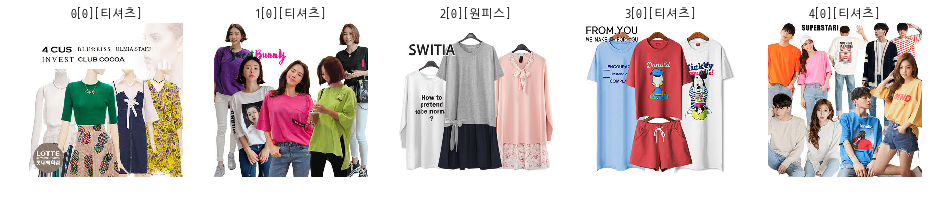

In [38]:
analyze_preds(out)

In [65]:
def print_result(out, wepick_slot_dic):
    for s, did, title, cate in out:
        org_slot = wepick_slot_dic[did] if did in wepick_slot_dic else -1
        print((s, did, title, org_slot, cate))
            

In [66]:
print_result(out, wepick_slot_dic)

(0.39164051695433766, 3207879, '[9만쿠폰] LG올뉴그램 15ZD980-GX5BK', 37, '노트북 38cm 이상')
(0.2588464278639869, 3526985, '[원더쿠폰] 봄 귀걸이,추가할인쿠폰', 28, '귀걸이')
(0.255577486000383, 3529165, '[하객패션] 락피쉬 18년S/S+20%쿠폰!', 46, '여성단화')
(0.25122677762432266, 3346365, '[결혼해봄] 위닉스 제습기 5종', 60, '제습기')
(0.227416325504876, 3521785, '[쿠폰할인] 중고폰 노트5/S7/엣지', 51, '공기계-미사용/미개봉')
(0.21150304279103943, 3512421, '[투데이특가] 휴대용 핸디 선풍기!', 85, '휴대용 선풍기')
(0.207943248305457, 3528363, '[하객패션] 백화점 잡화 267종! +20%', 27, '벨트')
(0.20712490302218847, 3524294, '[투데이특가] 여심저격 클루나드시계', 83, '패션시계')
(0.18177386129693218, 3505573, '[무료배송] 까만색 잇몸치약 130g ', 29, '칫솔/치약')
(0.16928786866462184, 3528550, '[투데이특가] 시카미백스팟세럼&쿠션', 61, '에센스/앰플')
(0.14739656622656086, 3524983, '[쿠폰할인] 코지마 안마의자 ', 25, '안마의자')
(0.1467108918031103, 3527236, '[투데이특가] 노파머스 대용량 샴푸', 54, '샴푸/린스')
(0.13589995926044418, 3500355, '[투데이특가] 좋은느낌 생리대 38+38', 47, '화이트')
(0.13386824372484668, 3521723, '[투데이특가] 샤오미 공기청정기', 57, '공기청정기')
(0.12465892126583372, 3521487, '[컬러풀] GTX1080 8GB 

### mongoDB for ActionInfos2

In [67]:
client = MongoClient(host='35.190.239.204', port=27017, username='praha_read', password='praha!@#', authSource='praha')

db = client['praha']

col = db['memberActionInfos2']

In [68]:
def mg_get_ordered_dids(mid, lt_day="20180411", limit=32):
    """
    구매한 딜들을 조회
    """
    result = col.find({"mid":mid, 'ft.o':{"$ne":[]}, 'day':{"$lt":lt_day}}, {'day':1, 'ft.o': 1, '_id':0}).sort('day', pymongo.DESCENDING).limit(limit)
    out = set()
    for res in result:
        out.update(list(map(lambda x: x['did'], res['ft']['o'])))
    return out

In [69]:
def mg_get_clicked_dids(mid, lt_day="20180411", limit=32, use_search_induced_click=False):
    """
    클릭한 딜들을 조회
    """
    result = col.find({"mid":mid, 'ft.c':{"$ne":[]}, 'day':{"$lt":lt_day}}, {'day':1, 'ft.c': 1, '_id':0}).sort('day', pymongo.DESCENDING).limit(limit)
    out = set()
    for res in result:
        out.update(list(map(lambda x: x['did'], 
                            res['ft']['c'] if use_search_induced_click == False else filter(lambda x: x['s'] != '', res['ft']['c'])
                           )))
    return out

### 구매 did로 부터 랭킹 테스트

- 구매 did 들의 word2vec을 사용

In [70]:
dids = mg_get_ordered_dids(1000007, limit=32)

In [71]:
user_profile = es_gather_word2vec_dids(list(dids))

In [72]:
scores = calc_rank(user_profile, deal_profile_dic)

In [73]:
out = get_refined_scores(scores, extra_dic)

: 0.4362735454799641/여성단화,0.39178555386983765/남성 티셔츠/상의 기타,0.3482256442147712/아동공용의류,0.33059816638138617/안마의자,0.3193822394078564/아동공용의류


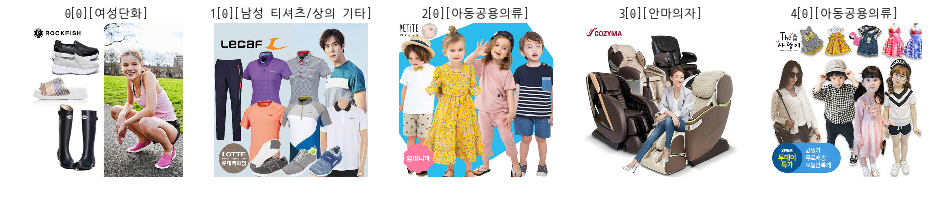

In [74]:
analyze_preds(out)

In [75]:
out

[(0.4362735454799641, 3529165, '[하객패션] 락피쉬 18년S/S+20%쿠폰!', '여성단화'),
 (0.39178555386983765, 3522395, '[롯데] 르까프 아동/성인 빅세일', '남성 티셔츠/상의 기타'),
 (0.3482256442147712, 3525068, '[엄마니까] 쁘띠뮤 여름 횡재가격!', '아동공용의류'),
 (0.33059816638138617, 3524983, '[쿠폰할인] 코지마 안마의자 ', '안마의자'),
 (0.3193822394078564, 3527053, '[투데이특가] 더사랑이 여름 아동복', '아동공용의류'),
 (0.2759517554178532, 3512593, '[무료배송] 봄 아동복 브랜드 연합전', '아동공용의류'),
 (0.2740090869307481, 3515704, '[투데이특가] 고급하이드로 더치커피', '커피/코코아음료'),
 (0.2625966043485338, 3513766, '[어린이날] 해피버스 7부/자가드내의', '내의/잠옷/속옷'),
 (0.24117999001202514, 3514331, '[주간특가] 캐릭터 아동 실내복 모음', '내의/잠옷/속옷'),
 (0.23690356861661138, 3525500, '[하객패션] 포커스 봄구성완벽해', '티셔츠'),
 (0.22620009924343873, 3515997, '[블랙데이] 짜장면 치즈 케이크 大', '초콜릿'),
 (0.2237135244723783, 3522402, '[무료배송] 에비수 본사특가 20%쿠폰', '티셔츠'),
 (0.21003386194647272, 3500355, '[투데이특가] 좋은느낌 생리대 38+38', '화이트'),
 (0.20713682826838875, 3490423, '[원더배송] 정관장 굿베이스 30포', '정관장'),
 (0.20712445630194684, 3515873, '[투데이특가] 레이스 덧신 1+1+1', '스타킹/양말'),
 (0.204605303129

In [76]:
print_result(out, wepick_slot_dic)

(0.4362735454799641, 3529165, '[하객패션] 락피쉬 18년S/S+20%쿠폰!', 46, '여성단화')
(0.39178555386983765, 3522395, '[롯데] 르까프 아동/성인 빅세일', 70, '남성 티셔츠/상의 기타')
(0.3482256442147712, 3525068, '[엄마니까] 쁘띠뮤 여름 횡재가격!', 75, '아동공용의류')
(0.33059816638138617, 3524983, '[쿠폰할인] 코지마 안마의자 ', 25, '안마의자')
(0.3193822394078564, 3527053, '[투데이특가] 더사랑이 여름 아동복', 43, '아동공용의류')
(0.2759517554178532, 3512593, '[무료배송] 봄 아동복 브랜드 연합전', 36, '아동공용의류')
(0.2740090869307481, 3515704, '[투데이특가] 고급하이드로 더치커피', 53, '커피/코코아음료')
(0.2625966043485338, 3513766, '[어린이날] 해피버스 7부/자가드내의', 55, '내의/잠옷/속옷')
(0.24117999001202514, 3514331, '[주간특가] 캐릭터 아동 실내복 모음', 41, '내의/잠옷/속옷')
(0.23690356861661138, 3525500, '[하객패션] 포커스 봄구성완벽해', 74, '티셔츠')
(0.22620009924343873, 3515997, '[블랙데이] 짜장면 치즈 케이크 大', 35, '초콜릿')
(0.2237135244723783, 3522402, '[무료배송] 에비수 본사특가 20%쿠폰', 44, '티셔츠')
(0.21003386194647272, 3500355, '[투데이특가] 좋은느낌 생리대 38+38', 47, '화이트')
(0.20713682826838875, 3490423, '[원더배송] 정관장 굿베이스 30포', 34, '정관장')
(0.20712445630194684, 3515873, '[투데이특가] 레이스 덧신 1+1+1', 

### 클릭 did로 부터 랭킹 테스트

- 유저가 클릭한 did 들의 word2vec을 사용
- use_search_induced_click==True 면, 검색후 클릭된 did만 가져온다.

In [77]:
dids= mg_get_clicked_dids(1000007, limit=64, use_search_induced_click=True)

In [78]:
user_profile = es_gather_word2vec_dids(list(dids))

In [79]:
scores = calc_rank(user_profile, deal_profile_dic)

In [80]:
out = get_refined_scores(scores, extra_dic)

: 0.39164051695433766/노트북 38cm 이상,0.2588464278639869/귀걸이,0.255577486000383/여성단화,0.25122677762432266/제습기,0.227416325504876/공기계-미사용/미개봉


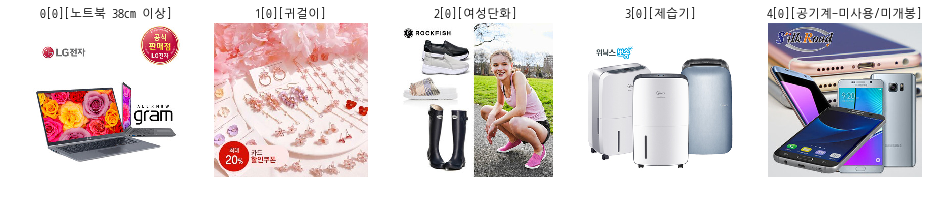

In [81]:
analyze_preds(out)

In [82]:
print_result(out, wepick_slot_dic)

(0.39164051695433766, 3207879, '[9만쿠폰] LG올뉴그램 15ZD980-GX5BK', 37, '노트북 38cm 이상')
(0.2588464278639869, 3526985, '[원더쿠폰] 봄 귀걸이,추가할인쿠폰', 28, '귀걸이')
(0.255577486000383, 3529165, '[하객패션] 락피쉬 18년S/S+20%쿠폰!', 46, '여성단화')
(0.25122677762432266, 3346365, '[결혼해봄] 위닉스 제습기 5종', 60, '제습기')
(0.227416325504876, 3521785, '[쿠폰할인] 중고폰 노트5/S7/엣지', 51, '공기계-미사용/미개봉')
(0.21150304279103943, 3512421, '[투데이특가] 휴대용 핸디 선풍기!', 85, '휴대용 선풍기')
(0.207943248305457, 3528363, '[하객패션] 백화점 잡화 267종! +20%', 27, '벨트')
(0.20712490302218847, 3524294, '[투데이특가] 여심저격 클루나드시계', 83, '패션시계')
(0.18177386129693218, 3505573, '[무료배송] 까만색 잇몸치약 130g ', 29, '칫솔/치약')
(0.16928786866462184, 3528550, '[투데이특가] 시카미백스팟세럼&쿠션', 61, '에센스/앰플')
(0.14739656622656086, 3524983, '[쿠폰할인] 코지마 안마의자 ', 25, '안마의자')
(0.1467108918031103, 3527236, '[투데이특가] 노파머스 대용량 샴푸', 54, '샴푸/린스')
(0.13589995926044418, 3500355, '[투데이특가] 좋은느낌 생리대 38+38', 47, '화이트')
(0.13386824372484668, 3521723, '[투데이특가] 샤오미 공기청정기', 57, '공기청정기')
(0.12465892126583372, 3521487, '[컬러풀] GTX1080 8GB 